This is the implementation notebook for [this article](https://medium.com/@The-Quant-Trading-Room/the-ultimate-trading-strategy-how-to-combine-kelly-criteria-and-monte-carlo-simulation-d9ce8cc2c2bc)

In [1]:
!pip install itables
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import yfinance as yf
from tqdm import tqdm
import seaborn as sns
sns.set()

# Interactive tables in Jupyter Notebook/Lab
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

# Interactive tables in Google Colab
from google.colab import data_table
data_table.enable_dataframe_formatter()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.6 MB/s eta 0:00:00


In [2]:
def get_price_and_rate_history():

    bad_start = '2001-07-31'
    good_start = '2012-04-01'
    end = '2020-12-31'
    # price history
    data = yf.download('SPY', start=bad_start, end=end)
    # we just need close data
    data.drop(['Open', 'High', 'Low', 'Volume', 'Adj Close'],
              axis=1,
              inplace=True)

    # obtain US Treasury nominal 1-month rate for risk free rate
    treasury_data = yf.download("^IRX", start=bad_start, end=end)
    rates = treasury_data['Adj Close']


    # remove the % from the rates
    # rates /= 100
    # fill rates for all days by filling missing days with the last value
    # this makes sure no days of price data are lost when joining
    #rates = rates.resample('D').last().ffill()
    data['1m_rate'] = rates/100
    data.fillna(method='ffill', inplace=True)
    #data.rename(columns = {'Nominal_1-month':'1m_rate'}, inplace = True)

    return data

def Kelly(data, period, kelly_cap=None,kelly_frac=1):

    data['returns'] = data['Close'].pct_change()
    data['log_returns'] = np.log(data['Close'])-np.log(data['Close'].shift(1))
    data['rollstd'] = data.log_returns.rolling(period).std()
    data['rollmean'] = data.log_returns.rolling(period).mean()
    data['r_daily'] = np.log((1+data['1m_rate']) ** (1/period))

    # kelly value = ((mu - r) / sigma**2) * kelly_frac
    data['kelly_value'] = ((data['rollmean']-data['r_daily'])
                            /data['rollstd']**2)*kelly_frac

    # convert to 0 all kelly_values that are <= 0
    data['kelly_factor'] = np.where(data.kelly_value < 0, 0, data.kelly_value)
    data['kelly_factor'] = np.where(data.kelly_factor >= kelly_cap,
                                    kelly_cap,
                                    data.kelly_factor)

    # put a max cap on the kelly factor
    if kelly_cap:
        data['kelly_factor'] = np.where(data.kelly_factor >= kelly_cap,
                                        kelly_cap,
                                        data.kelly_factor)
    data = data.dropna()

    return data

def monte_carlo_simulation(num_sims, sim_steps, X0, mu, sigma, T):
    '''
    num_sims (int): the number of simulations to run
    sim_steps (int): the number of steps in each simulation
    X0 (float): the initial value of the stock
    mu (float): expected return
    sigma (float): the volitility of the stock
    T (int): the time horizon of the simulation
    '''

    dt = T / sim_steps
    W = np.cumsum(np.random.randn(num_sims, sim_steps) * np.sqrt(dt), axis=1)
    X = X0 * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * W)

    # calculate the mean and std
    final_vals = X[:, -1]
    mean = round(np.mean(final_vals), 2)
    stdev = round(np.std(final_vals), 2)

    return pd.Series([mean, stdev])

def fill_monte(data, period):

    # monte carlo for each iteration of the data so daily
    mc_results = data.apply(lambda row: monte_carlo_simulation(num_sims=100,
                                                               sim_steps=period,
                                                               X0=row['Close'],
                                                               mu=row['rollmean'],
                                                               sigma=row['rollstd'],
                                                               T=1), axis=1)

    mc_results.rename(columns = {0:'mc_mean', 1:'mc_std'}, inplace = True)

    # join mc_mean and mc_std tuples as data columns
    data = data.join(mc_results)
    # create a column of the upper price bound (1 standard deviation from the mean)
    data['up1'] = data.mc_mean + data.mc_std
    # shift the up1, mc_mean, and mc_std columns by 1 day -- allows us to assess
    # if we are outside the upper bound of the previous day's monte carlo
    data[['up1', 'mc_mean', 'mc_std']] = data[['up1', 'mc_mean', 'mc_std']].shift(1)

    return data

def long_Kelly_strat(data, period, MC=False):

    # generates np array for length of sim to track portfolio ratios
    cash = np.zeros(data.shape[0])
    equity = cash.copy()
    portfolio = cash.copy()

    # starts portfolio and cash at 1
    portfolio[0] = 1
    cash[0] = 1
    equity[0] = 0

    for i, _row in enumerate(tqdm(data.iterrows())):
        if i >= 1:
            # this assigns row to all the data in 1 period of the data so the index, close, returns, log returns, kelly_factor
            row = _row[1]
            # If there is no kelly value then the portfolio just adds the previous time period's portfolio and cash
            if np.isnan(row['kelly_factor']):
                portfolio[i] += portfolio[i-1]
                cash[i] += cash[i-1]
                continue

            if MC == True:

                z = (row['Close'] - row['mc_mean']) / row['mc_std']

                portfolio[i] += (cash[i-1] * (1 + row['r_daily'])) + (equity[i-1] * (1 + row['returns']))

                # if outside of 1 standard deviation, exit the percent of the position equal to z score minus 1
                if z > 1.0:
                    equity[i] = equity[i-1] * (1 + row['returns'])
                    cash[i] = cash[i-1] * (1 + row['r_daily'])

                    amt_out = equity[i] * (z-1)
                    equity[i] -= amt_out
                    cash[i] += amt_out

                # if z score within 1 standard deviation or less than, use kelly criteria to allocate position
                else:
                    #reweights portfolio for each iteration of the data so daily
                    equity[i] += portfolio[i] * row['kelly_factor']
                    cash[i] += portfolio[i] * (1- row['kelly_factor'])

            else:
                #reweights portfolio for each iteration of the data so daily
                portfolio[i] += (cash[i-1] * (1 + row['r_daily'])) + (equity[i-1] * (1 + row['returns']))
                equity[i] += portfolio[i] * row['kelly_factor']
                cash[i] += portfolio[i] * (1- row['kelly_factor'])

    data['cash'] = cash
    data['equity'] = equity
    data['portfolio'] = portfolio
    data['strat_returns'] = data['portfolio'].pct_change()
    data['strat_log_returns'] = np.log(data['portfolio']) - np.log(data['portfolio'].shift(1))
    data['strat_cum_returns'] = data['strat_log_returns'].cumsum()
    data['cum_returns'] = data['log_returns'].cumsum()

    return data

In [3]:
period = 252

k_data = get_price_and_rate_history()
mc_data = get_price_and_rate_history()

reg_k_data = Kelly(k_data, period, kelly_frac=1)
half_k_data = Kelly(k_data, period, kelly_frac=.5)
qtr_k_data = Kelly(k_data, period, kelly_frac=.25)

reg_mc_data = Kelly(mc_data, period, kelly_cap=3, kelly_frac=1)
half_mc_data = Kelly(mc_data, period, kelly_cap=3, kelly_frac=.5)
qtr_mc_data = Kelly(mc_data, period, kelly_cap=3, kelly_frac=.25)

reg_mc_data = fill_monte(reg_mc_data, period)
half_mc_data = fill_monte(half_mc_data, period)
qtr_mc_data = fill_monte(qtr_mc_data, period)

reg_kelly = long_Kelly_strat(reg_k_data, period)
half_kelly = long_Kelly_strat(half_k_data, period)
qtr_kelly = long_Kelly_strat(qtr_k_data, period)

mc_reg_kelly = long_Kelly_strat(reg_mc_data, period, MC=True)
mc_half_kelly = long_Kelly_strat(half_mc_data, period, MC=True)
mc_qtr_kelly = long_Kelly_strat(qtr_mc_data, period, MC=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


4634it [00:00, 15669.28it/s]
4634it [00:00, 15653.11it/s]
4634it [00:00, 15661.09it/s]
4634it [00:00, 14650.54it/s]
4634it [00:00, 13554.30it/s]
4634it [00:00, 14242.00it/s]


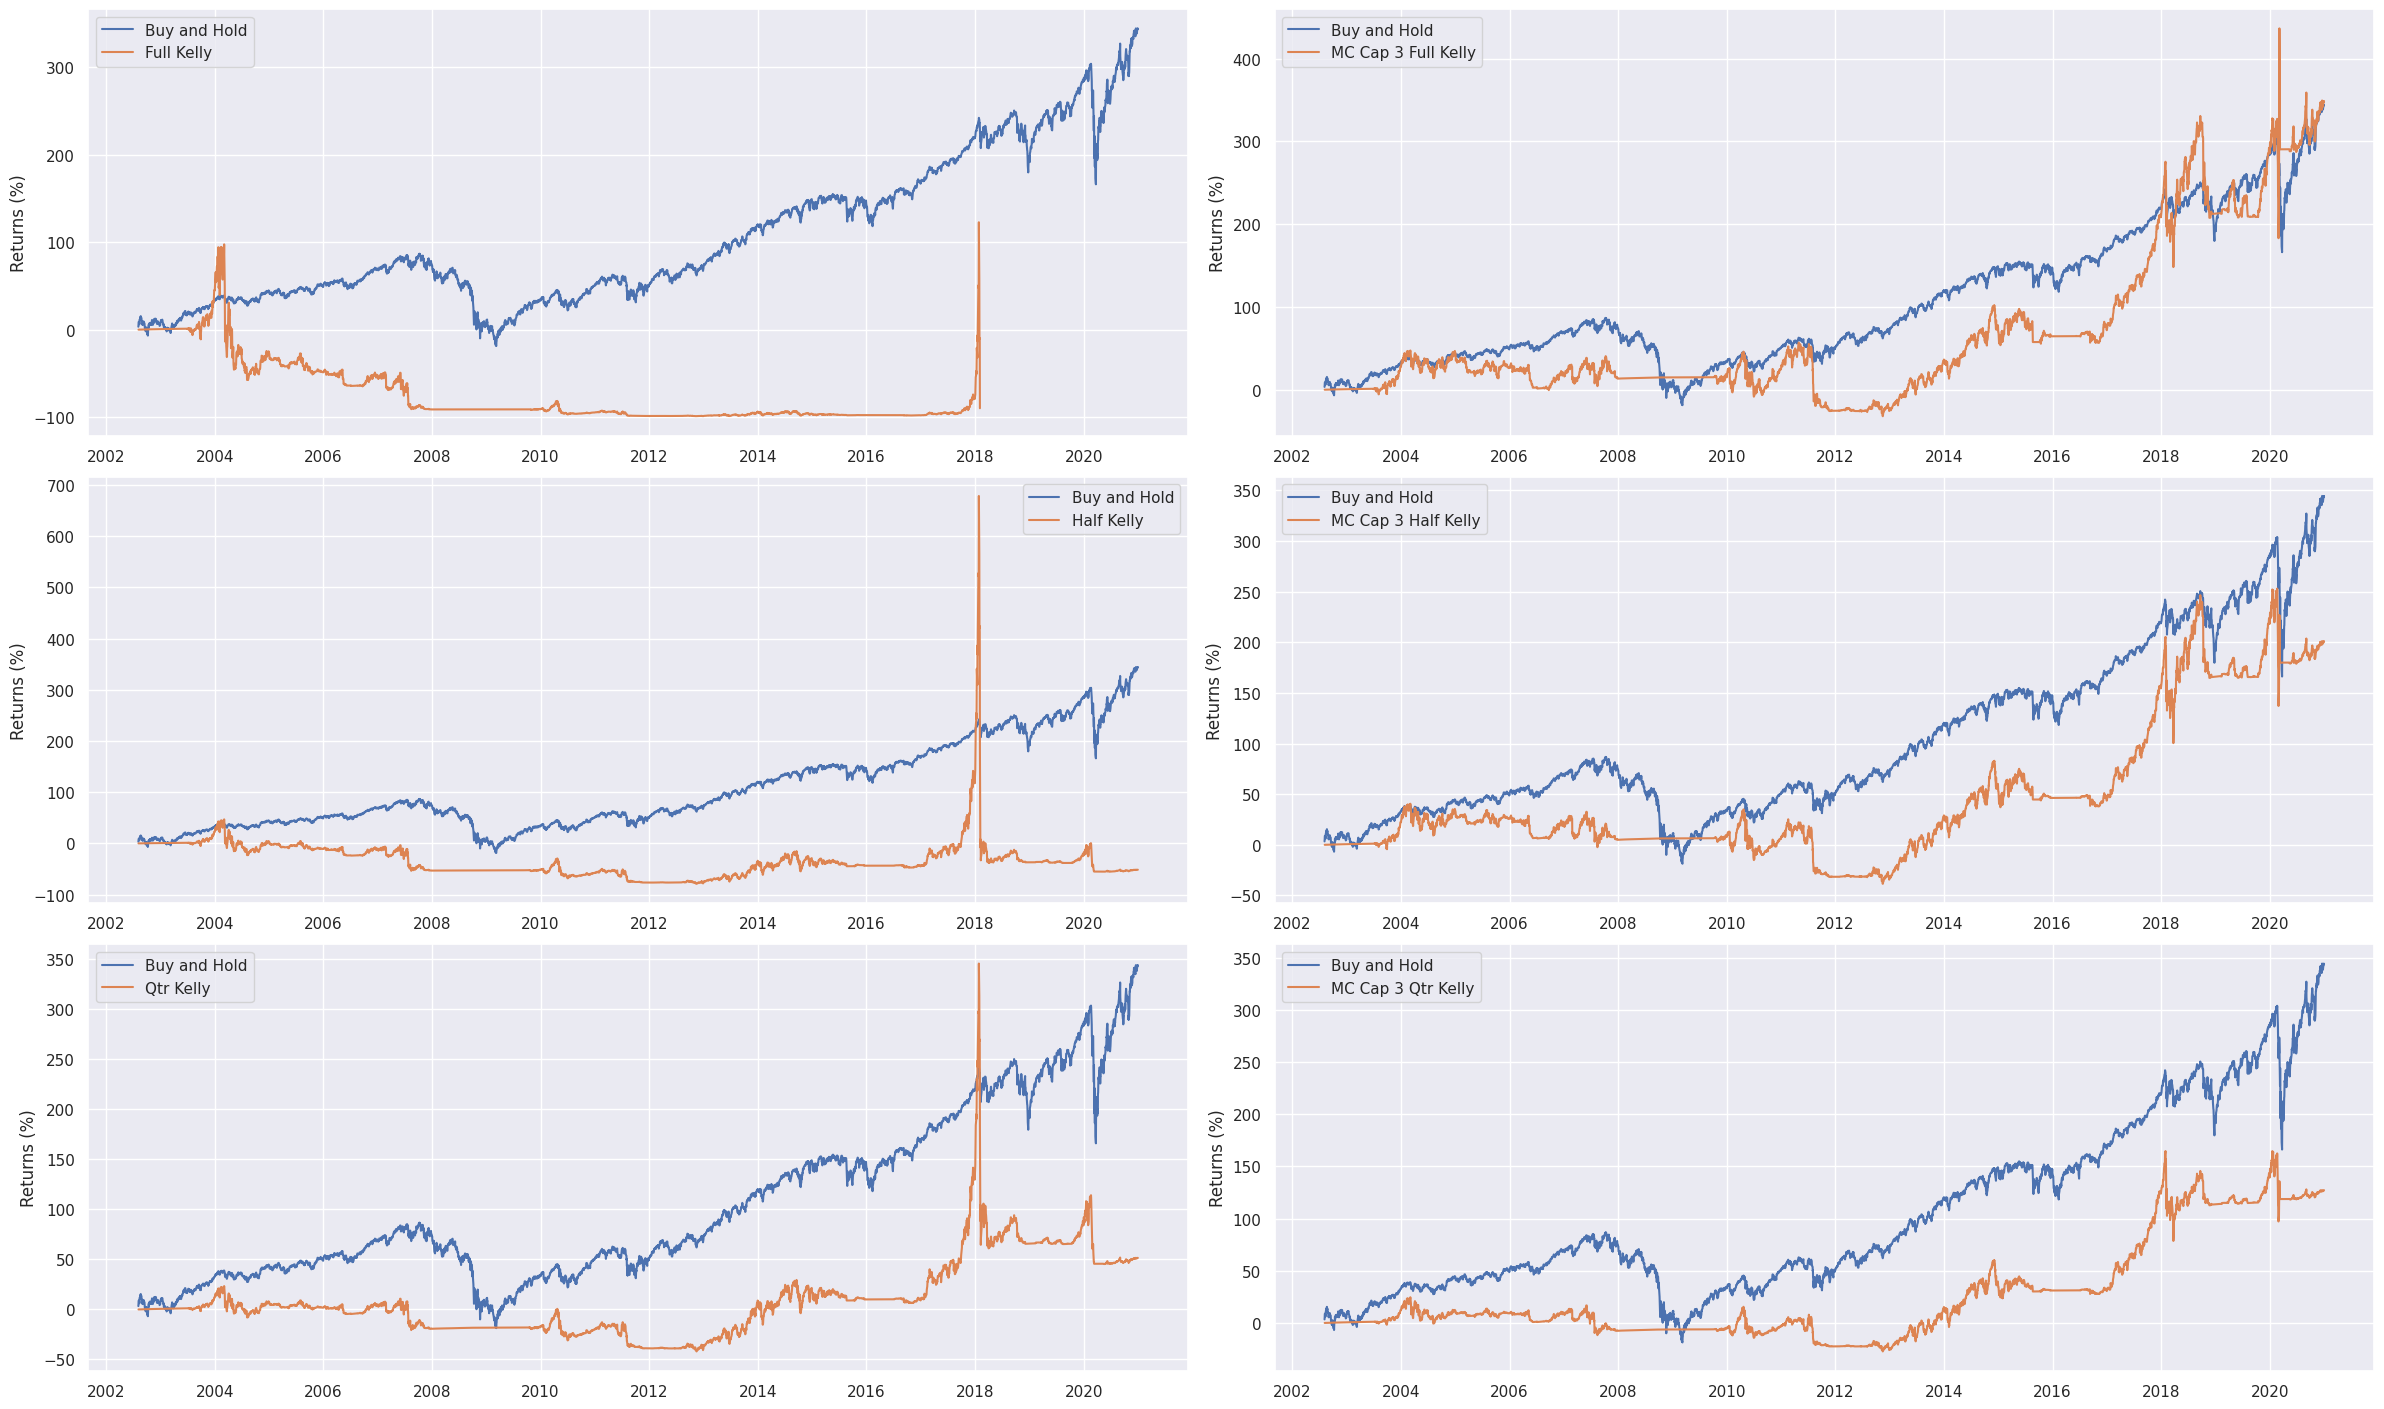

In [4]:


# Plot Everything
fig, ax = plt.subplots(3, 2, figsize=(24, 16))

# Control
SPY = (np.exp(reg_kelly['cum_returns']) -1) *100

# Reg Kelly
reg_cumrets = (np.exp(reg_kelly['strat_cum_returns']) -1) *100
ax[0, 0].plot(SPY , label='Buy and Hold')
ax[0, 0].plot(reg_cumrets, label='Full Kelly')
ax[0, 0].set_ylabel('Returns (%)')
ax[0, 0].legend()

half_cumrets = (np.exp(half_kelly['strat_cum_returns']) -1) * 100
ax[1, 0].plot(SPY, label='Buy and Hold')
ax[1, 0].plot(half_cumrets, label='Half Kelly')
ax[1, 0].set_ylabel('Returns (%)')
ax[1, 0].legend()

qtr_cumrets = (np.exp(qtr_kelly['strat_cum_returns']) -1) * 100
ax[2, 0].plot(SPY, label='Buy and Hold')
ax[2, 0].plot(qtr_cumrets, label='Qtr Kelly')
ax[2, 0].set_ylabel('Returns (%)')
ax[2, 0].legend()

mc_reg_cumrets = (np.exp(mc_reg_kelly['strat_cum_returns']) -1) *100
ax[0, 1].plot(SPY, label='Buy and Hold')
ax[0, 1].plot(mc_reg_cumrets, label='MC Cap 3 Full Kelly')
ax[0, 1].set_ylabel('Returns (%)')
ax[0, 1].legend()

mc_half_cumrets = (np.exp(mc_half_kelly['strat_cum_returns']) -1) * 100
ax[1, 1].plot(SPY, label='Buy and Hold')
ax[1, 1].plot(mc_half_cumrets, label='MC Cap 3 Half Kelly')
ax[1, 1].set_ylabel('Returns (%)')
ax[1, 1].legend()

mc_qtr_cumrets = (np.exp(mc_qtr_kelly['strat_cum_returns']) -1) * 100
ax[2, 1].plot(SPY, label='Buy and Hold')
ax[2, 1].plot(mc_qtr_cumrets, label='MC Cap 3 Qtr Kelly')
ax[2, 1].set_ylabel('Returns (%)')
ax[2, 1].legend()

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

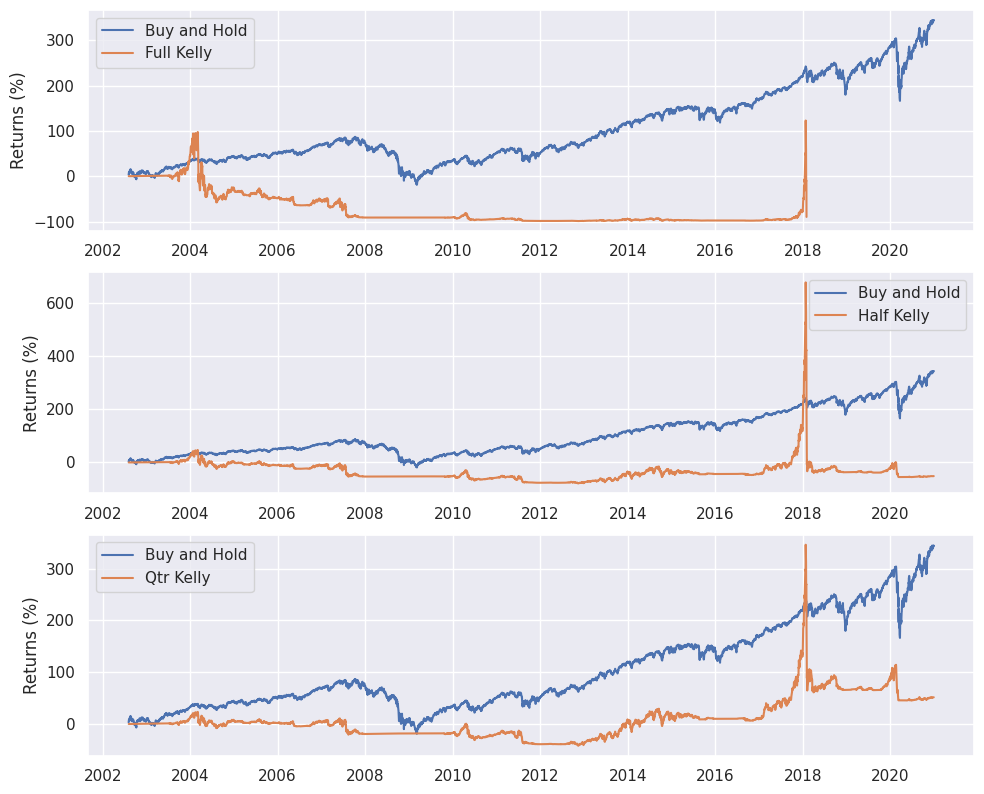

In [5]:
# Plot Everything
fig, ax = plt.subplots(3, 1, figsize=(10, 9))

# Control
SPY = (np.exp(reg_kelly['cum_returns']) -1) *100

# Reg Kelly
reg_cumrets = (np.exp(reg_kelly['strat_cum_returns']) -1) *100
ax[0].plot(SPY , label='Buy and Hold')
ax[0].plot(reg_cumrets, label='Full Kelly')
ax[0].set_ylabel('Returns (%)')
ax[0].legend()

half_cumrets = (np.exp(half_kelly['strat_cum_returns']) -1) * 100
ax[1].plot(SPY, label='Buy and Hold')
ax[1].plot(half_cumrets, label='Half Kelly')
ax[1].set_ylabel('Returns (%)')
ax[1].legend()

qtr_cumrets = (np.exp(qtr_kelly['strat_cum_returns']) -1) * 100
ax[2].plot(SPY, label='Buy and Hold')
ax[2].plot(qtr_cumrets, label='Qtr Kelly')
ax[2].set_ylabel('Returns (%)')
ax[2].legend()

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

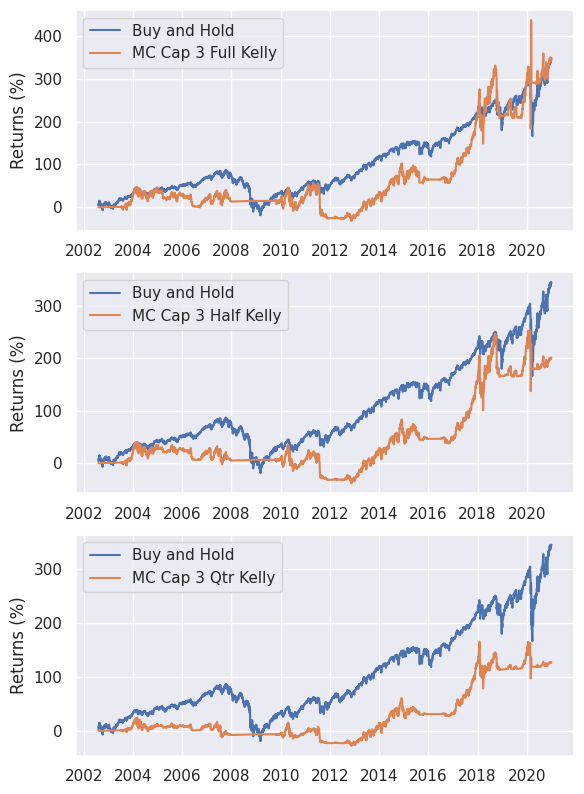

In [6]:
# Plot Everything
fig, ax = plt.subplots(3, 1, figsize=(6, 9))

# Control
SPY = (np.exp(reg_kelly['cum_returns']) -1) *100

mc_reg_cumrets = (np.exp(mc_reg_kelly['strat_cum_returns']) -1) *100
ax[0].plot(SPY, label='Buy and Hold')
ax[0].plot(mc_reg_cumrets, label='MC Cap 3 Full Kelly')
ax[0].set_ylabel('Returns (%)')
ax[0].legend()

mc_half_cumrets = (np.exp(mc_half_kelly['strat_cum_returns']) -1) * 100
ax[1].plot(SPY, label='Buy and Hold')
ax[1].plot(mc_half_cumrets, label='MC Cap 3 Half Kelly')
ax[1].set_ylabel('Returns (%)')
ax[1].legend()

mc_qtr_cumrets = (np.exp(mc_qtr_kelly['strat_cum_returns']) -1) * 100
ax[2].plot(SPY, label='Buy and Hold')
ax[2].plot(mc_qtr_cumrets, label='MC Cap 3 Qtr Kelly')
ax[2].set_ylabel('Returns (%)')
ax[2].legend()

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()